In [1]:
import requests
import json
import configparser
import xlsxwriter
import time
from datetime import datetime

In [2]:
class ErrorStack(Exception):
    def __init___(self,args):
        Exception.__init__(self,"my exception was raised with arguments {0}".format(args))
        self.args = args

In [3]:
uriBase                = "https://www.space-track.org"
requestLogin           = "/ajaxauth/login"
requestCmdAction       = "/basicspacedata/query" 
requestFindStarlinks   = "/class/tle_latest/NORAD_CAT_ID/>40000/ORDINAL/1/OBJECT_NAME/STARLINK~~/format/json/orderby/NORAD_CAT_ID%20asc"
requestOMMStarlink1    = "/class/omm/NORAD_CAT_ID/"
requestOMMStarlink2    = "/orderby/EPOCH%20asc/format/json"
requestZarya           = "/class/tle_latest/NORAD_CAT_ID/25544/orderby/ORDINAL%20asc/limit/1/"

In [4]:
config = configparser.ConfigParser()
config.read("config.ini")
configUsr = config.get("SpaceTrack","username")
configPwd = config.get("SpaceTrack","password")
siteCred = {'identity': configUsr, 'password': configPwd}

In [5]:
# use requests package to drive the RESTful session with space-track.org
with requests.Session() as session:
    # run the session in a with block to force session to close if we exit

    # need to log in first. note that we get a 200 to say the web site got the data, not that we are logged in
    resp = session.post(uriBase + requestLogin, data = siteCred)
    if resp.status_code != 200:
        raise ErrorStack(resp, "POST fail on login")

In [6]:
q = "https://www.space-track.org/basicspacedata/query/class/tle_latest/NORAD_CAT_ID/25544/orderby/ORDINAL%20asc/limit/1/emptyresult/show"

In [7]:
resp = session.get(q)

In [8]:
data = resp.json()
data

[{'ORDINAL': '1',
  'COMMENT': 'GENERATED VIA SPACETRACK.ORG API',
  'ORIGINATOR': '18 SPCS',
  'NORAD_CAT_ID': '25544',
  'OBJECT_NAME': 'ISS (ZARYA)',
  'OBJECT_TYPE': 'PAYLOAD',
  'CLASSIFICATION_TYPE': 'U',
  'INTLDES': '98067A',
  'EPOCH': '2020-02-22 13:37:40',
  'EPOCH_MICROSECONDS': '462752',
  'MEAN_MOTION': '15.49190588',
  'ECCENTRICITY': '0.0004773',
  'INCLINATION': '51.6431',
  'RA_OF_ASC_NODE': '200.5391',
  'ARG_OF_PERICENTER': '305.6846',
  'MEAN_ANOMALY': '143.5584',
  'EPHEMERIS_TYPE': '0',
  'ELEMENT_SET_NO': '999',
  'REV_AT_EPOCH': '21409',
  'BSTAR': '3.6272e-05',
  'MEAN_MOTION_DOT': '1.56e-05',
  'MEAN_MOTION_DDOT': '0',
  'FILE': '2707895',
  'TLE_LINE0': '0 ISS (ZARYA)',
  'TLE_LINE1': '1 25544U 98067A   20053.56782943  .00001560  00000-0  36272-4 0  9990',
  'TLE_LINE2': '2 25544  51.6431 200.5391 0004773 305.6846 143.5584 15.49190588214091',
  'OBJECT_ID': '1998-067A',
  'OBJECT_NUMBER': '25544',
  'SEMIMAJOR_AXIS': '6797.229',
  'PERIOD': '92.951',
  'APOG

In [9]:
print(data[0]["TLE_LINE0"])
print(data[0]["TLE_LINE1"])
print(data[0]["TLE_LINE2"])

0 ISS (ZARYA)
1 25544U 98067A   20053.56782943  .00001560  00000-0  36272-4 0  9990
2 25544  51.6431 200.5391 0004773 305.6846 143.5584 15.49190588214091


2458900.969619881
(3, 300)
hw was None so set to: 7403.44447606047
centers are:  [2.864956300965787, 0.0, 0.0]
hw is:        7403.44447606047


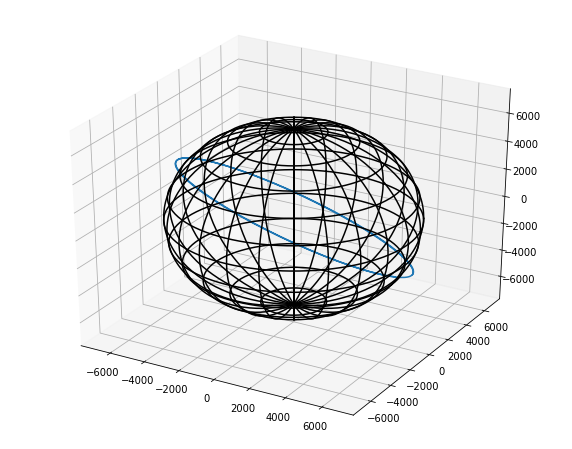

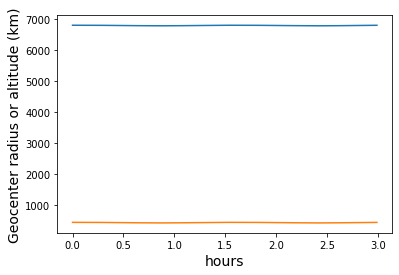

In [11]:
def makecubelimits(axis, centers=None, hw=None):
    lims = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()
    if centers == None:
        centers = [0.5*sum(pair) for pair in lims] 

    if hw == None:
        widths  = [pair[1] - pair[0] for pair in lims]
        hw      = 0.5*max(widths)
        ax.set_xlim(centers[0]-hw, centers[0]+hw)
        ax.set_ylim(centers[1]-hw, centers[1]+hw)
        ax.set_zlim(centers[2]-hw, centers[2]+hw)
        print("hw was None so set to:", hw)
    else:
        try:
            hwx, hwy, hwz = hw
            print("ok hw requested: ", hwx, hwy, hwz)

            ax.set_xlim(centers[0]-hwx, centers[0]+hwx)
            ax.set_ylim(centers[1]-hwy, centers[1]+hwy)
            ax.set_zlim(centers[2]-hwz, centers[2]+hwz)
        except:
            print("nope hw requested: ", hw)
            ax.set_xlim(centers[0]-hw, centers[0]+hw)
            ax.set_ylim(centers[1]-hw, centers[1]+hw)
            ax.set_zlim(centers[2]-hw, centers[2]+hw)

    return centers, hw

TLE = """1 25544U 98067A   20052.46881914 -.00003279  00000-0 -50976-4 0  9994
2 25544  51.6384 205.9826 0005039 300.0407 135.8886 15.49180919213925"""
L1, L2 = TLE.splitlines()

from skyfield.api import Loader, EarthSatellite
from skyfield.timelib import Time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

halfpi, pi, twopi = [f*np.pi for f in [0.5, 1, 2]]
degs, rads = 180/pi, pi/180

load = Loader('~/Documents/fishing/SkyData')
data = load('de421.bsp')
ts   = load.timescale()

planets = load('de421.bsp')
earth   = planets['earth']

Roadster = EarthSatellite(L1, L2)

print(Roadster.epoch.tt)
hours = np.arange(0, 3, 0.01)

time = ts.utc(2020, 18, 51, hours)

Rpos    = Roadster.at(time).position.km
Rposecl = Roadster.at(time).ecliptic_position().km

print(Rpos.shape)

re = 6378.

theta = np.linspace(0, twopi, 201)
cth, sth, zth = [f(theta) for f in [np.cos, np.sin, np.zeros_like]]
lon0 = re*np.vstack((cth, zth, sth))
lons = []
for phi in rads*np.arange(0, 180, 15):
    cph, sph = [f(phi) for f in [np.cos, np.sin]]
    lon = np.vstack((lon0[0]*cph - lon0[1]*sph,
                     lon0[1]*cph + lon0[0]*sph,
                     lon0[2]) )
    lons.append(lon)

lat0 = re*np.vstack((cth, sth, zth))
lats = []
for phi in rads*np.arange(-75, 90, 15):
    cph, sph = [f(phi) for f in [np.cos, np.sin]]
    lat = re*np.vstack((cth*cph, sth*cph, zth+sph))
    lats.append(lat)

if True:    
    fig = plt.figure(figsize=[10, 8])  # [12, 10]

    ax  = fig.add_subplot(1, 1, 1, projection='3d')

    x, y, z = Rpos
    ax.plot(x, y, z)
    for x, y, z in lons:
        ax.plot(x, y, z, '-k')
    for x, y, z in lats:
        ax.plot(x, y, z, '-k')

    centers, hw = makecubelimits(ax)

    print("centers are: ", centers)
    print("hw is:       ", hw)

    plt.show()

r_Roadster = np.sqrt((Rpos**2).sum(axis=0))
alt_roadster = r_Roadster - re

if True:
    plt.figure()
    plt.plot(hours, r_Roadster)
    plt.plot(hours, alt_roadster)
    plt.xlabel('hours', fontsize=14)
    plt.ylabel('Geocenter radius or altitude (km)', fontsize=14)
    plt.show()